In [1]:
import sys
import time
from tqdm.notebook import trange, tqdm

# Packages for direct database access
# %pip install psycopg2
import psycopg2
import json
import requests

# Packages for data and number handling
import numpy as np
import pandas as pd
import math

# Packages for calculating current time and extracting ZTF data to VOTable
from astropy.time import Time
from astropy.table import Table, Column, unique, vstack
from astropy.io.votable import parse_single_table, from_table, writeto
from datetime import datetime

# Package for nearMOC filtering
from pystilts import tpipe

# Package for coordinates
from astropy.coordinates import SkyCoord
from astropy import units as u

# Virtual observatory package
import pyvo as vo

# Package for footprint geometric descriptions
import shapely.geometry as sg
import shapely.ops as so

# Packages for display and data plotting, if desired
from IPython.display import HTML
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Variables to specify:
## the type of classifier we're interested in retrieving ZTF objects from (can be 'lightcurve' or 'stamp')
## whether we are looking up novel objects or all objects
## the number of days we want to look back on
## the filename for the VOTABLE of all retrieved ZTF objects
## the filename for the VOTABLE of ZTF objects near the Chandra MOC

classifier = 'lightcurve'
novel_objects = False
days_ago = 2.0
filename = 'ztf_api_lc_objects_unique.xml'
outfile = 'ztf_CSC_inMOC.xml'

In [3]:
# Connecting to the ZTF database
url = "https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']
conn = psycopg2.connect(
    dbname=params['dbname'], 
    user=params['user'], 
    host=params['host'], 
    password=params['password'])

# Specifying the detection date bounds of the database query
min_lastmjd = np.floor(Time(datetime.today(), scale='utc').mjd) - (days_ago)
max_lastmjd = np.floor(Time(datetime.today(), scale='utc').mjd) - (days_ago-1.0)

# Defining classifier name and version for the database query
classifiers = {'stamp': ["\'stamp_classifier\'", "\'stamp_classifier_1.0.4\'"],
               'lightcurve': ["\'lc_classifier\'", "\'hierarchical_rf_1.1.0\'"]}
classifier_name = classifiers[classifier][0]
classifier_version = classifiers[classifier][1]

# Main query string
query='''
SELECT
    object.oid, object.meanra, object.meandec, object.sigmara, object.sigmadec,
    object.firstmjd, object.lastmjd, object.ndet,
    probability_oid.classifier_name, probability_oid.class_name,
    probability_oid.ranking, probability_oid.probability

FROM
    object INNER JOIN (
        SELECT
            oid, classifier_name, class_name, ranking, probability
        FROM
            probability
        WHERE
            classifier_name = %s
            AND classifier_version = %s
            AND ranking = 1
    ) AS probability_oid
    ON object.oid = probability_oid.oid

WHERE
    object.lastmjd >= %s
    AND object.lastmjd <= %s
''' % (classifier_name, classifier_version, str(min_lastmjd), str(max_lastmjd))

# Start timer
start = time.time()

# Run query - outputs as a pd.DataFrame
dbobjects = pd.read_sql_query(query, conn)

# End timer
end = time.time()
print(f"Runtime of the DDB query is {end - start}")

Runtime of the DDB query is 7.5898942947387695


In [ ]:
# Sorting detections by lastMJD, firstMJD, and OID in descending order
dbobjects = dbobjects.sort_values(by=['lastmjd', 'firstmjd', 'oid'], ascending=False)

# Filtering objects based on if novel_objects boolean is true
lim_ndets = {'stamp': 1, 'lightcurve': 6}
lim_ndet = lim_ndets[classifier]
mask = (dbobjects['ndet'] <= lim_ndet)
apiobjects = dbobjects[mask]
if (not novel_objects):
    apiobjects = dbobjects

# Count number of OIDs that correspond to each class name
print('Total rows : %i' % (len(apiobjects.index)))

# Identify duplicate OID entries - rows with same OID but different classes and probabilities
obj_oid = apiobjects.groupby(['oid'])
duplicates = []
for key in obj_oid.groups.keys():
    l = obj_oid.groups[key].size
    if l > 1:
        oid = key
        duplicates.append(oid)

print('Number of OIDs with more than one row : %i' % (len(duplicates)))
print('Number of unique OIDs : %i' % len(obj_oid))

In [4]:
# Defining a function that allows you to export the dataframe into a VOTable
def export_object_data(objects_df, filename):
    # Filling the masked values with the string 'NaN'
    objects_filled = objects_df.fillna('None')

    # Converting filled dataframe to astropy Table, then astropy VOTableFile, 
    # then exporting into .xml
    full_dt = Table.from_pandas(objects_filled)
    votable = from_table(full_dt)
    writeto(votable, filename)

# Export VOTable with only unique OIDs
unique_df = apiobjects.drop_duplicates(subset=['oid'])
export_object_data(unique_df, filename)

Total rows : 56762
Number of OIDs with more than one row : 68
Number of unique OIDs : 56694


In [ ]:
# Variable definition for pystilts code
mocLocation='/Users/cxc/CDAAnnotation/FITS_handling/ChandraMOC13_nograting.fits'
expression="""nearMoc(\\"%s\\", meanra, meandec, 0.02)""" % mocLocation
expression='"{0}"'.format(expression)

# Start timer
start = time.time()

# Running pystilts 'nearMOC' method
tpipe(infile=filename,
      ifmt='votable',
      ofmt='votable',
      omode='out',
      outfile=outfile, cmd='select %s'%expression)

# End timer
end = time.time()
print(f"Runtime of the pystils program is {end - start}")

# Convert outputted VOTABLE to astropy Table
ztfobjects = parse_single_table(outfile).to_table()
print('Number of ZTF obj filtered by nearMOC: %i' % len(np.unique(ztfobjects['oid'].filled())))

In [5]:
# Defining variables for cone search and initalizing cone search results array
skycoords = SkyCoord(ra=ztfobjects['meanra']*u.degree, 
                     dec=ztfobjects['meandec']*u.degree, 
                     frame='icrs')
maxrad = 50.0 * u.arcmin
csc_results = []

# Cone search service URL
cone = vo.dal.SCSService('https://cda.cfa.harvard.edu/cxcscs/coneSearch')

# Start timer
start = time.time()

# Running cone search in CSC for each ZTF object
for i in trange(len(ztfobjects), desc='Indexing'):
    results = cone.search(pos=skycoords[i], radius=maxrad)
    csc_results.append(results.to_table().as_array().data)

# End timer
end = time.time()
print(f"Runtime of the cone search program is {end - start}")

Runtime of the pystils program is 3.5094242095947266
Number of ZTF obj filtered by nearMOC: 1951



Runtime of the cone search program is 105.86282587051392


In [6]:
# Defining variables for tapservice query and initalizing results array
csc_res = np.asarray(csc_results, dtype=object)
concsc_res = np.concatenate(csc_res)
obsids = set(concsc_res['obsid'].astype(str))
tobsids = tuple(obsids)

# CSC tap service URL
tapservice = vo.dal.TAPService("https://cda.cfa.harvard.edu/cxctap/")

# Query string, filtering based on names returned via cone search
query = '''
SELECT o.obs_id, o.obs_creation_date, o.s_ra, o.s_dec, o.s_region
FROM ivoa.ObsCore AS o
WHERE o.dataproduct_type = 'event' AND o.obs_id IN {}
'''.format(tobsids)

# Start timer
start = time.time()

# Run tapservice query
tapresult = tapservice.search(query)

# End timer
end = time.time()
print(f"Runtime of the tapservice query is {end - start}")

Runtime of the tapservice query is 16.171313047409058


In [ ]:
# Formatting tapservice result table, getting rid of duplicate entries
tresult = tapresult.to_table()
for colname in tresult.colnames:
    if colname == 'obs_creation_date':
        tresult[colname]=Time(tresult[colname].astype(str), format='isot', scale='utc').mjd
    else:
        tresult[colname]=tresult[colname].astype(object)
tresult = unique(tresult, keys='obs_id')
tresult.add_index(['obs_id'])

In [ ]:
# Filtering ztf objects table to those with 1 or more cone search result
f = np.vectorize(np.size)
n_res = f(csc_res)
ztfobjects['n_res']=n_res
mask = (ztfobjects['n_res'] > 0)
maskedztf = ztfobjects[mask]
l = len(concsc_res)

# Initializing new data columns for tap service results
maskedztf['cxc_obs_id'] = np.full(len(maskedztf), None)
maskedztf['cxc_obs_status'] = np.full(len(maskedztf), None)
for colname in tresult.colnames[1:]:
    maskedztf['cxc_%s'%(colname)] = np.full(len(maskedztf), None)

# Formatting filtered ztf object array
mztf = maskedztf.as_array()
mztf_f = mztf.filled()

# Adding extra rows, according to the number of cone search results each ZTF object has
mztf_nres = n_res[n_res != 0]
mztf_fr = np.repeat(mztf,mztf_nres)

# Filling new data columns: CXC obsid and status
mztf_fr['cxc_obs_id'] = concsc_res['obsid']
mztf_fr['cxc_obs_status'] = concsc_res['status']

## Returns array akin to 
## np.array([index of item in b for item in a where (item in b = item in a)])
bobsids = np.array(list(set(tresult['obs_id'])))
a = mztf_fr['cxc_obs_id']
idx = np.where(np.in1d(a,bobsids))[0]

## Returns mdarray of tap service results according to passed list of obsids
tt = tresult.loc[a[idx]]

# Filling new data columns: remaining data from tap service query
for colname in tresult.colnames[3:]:
    mztf_fr['cxc_%s'%(colname)][idx] = tt[colname]

In [11]:
# Defining different tables for ztf objects with cone search matches in/out of footprint
ztfobs = Table(mztf_fr)
cxc_observed_statuses = ['archived', 'observed']
mask = np.in1d(ztfobs['cxc_obs_status'].astype(str),cxc_observed_statuses)
observedztf = ztfobs[mask]
nonobservedztf = ztfobs[~mask]

print('Total unique ZTF OIDs: %i' % len(np.unique(ztfobs['oid'].filled())))
print('ZTF OIDs with cone search matches that have footprint: %i' % len(np.unique(observedztf['oid'].filled())))
print('ZTF OIDs with cone search matches that do not have footprint: %i' % len(np.unique(nonobservedztf['oid'].filled())))

print('Total number of archived or observed footprints: %i' % len(observedztf))
print('Total number of scheduled, unobserved, or triggered footprints: %i' % len(nonobservedztf))

Total unique ZTF OIDs: 1943
ZTF OIDs with cone search matches that have footprint: 1943
ZTF OIDs with cone search matches that do not have footprint: 439
Total number of archived or observed footprints: 32635
Total number of scheduled, unobserved, or triggered footprints: 4318


In [13]:
# Initializing column for boolean that marks whether a ZTF object is in the chandra footprint
ztfobs['in_poly']=np.full(len(ztfobs), None)
ztf_in_poly=[]

# Start timer
start = time.time()

for i in trange(len(observedztf)):
    region = observedztf['cxc_s_region'].filled()[i]
    if (type(region)==type(None)):
        ztf_in_poly.append(None)
        continue
    
    # Constructing footprint region with shapely polygon
    region = region.decode().replace(")","").split('POLYGON')
    polygon_coords = [np.stack((a.split()[::2], a.split()[1::2]), axis=-1).astype(float) for a in region[1:]]

    polygons = [sg.Polygon(c) for c in polygon_coords]
    
    # Define ZTF object position as shapely point
    point = sg.Point(np.asarray([observedztf['meanra'][i],observedztf['meandec'][i]]).astype(float))
    
    # Use shapely within() method to determine if point is in polygon
    in_poly = set([point.within(poly) for poly in polygons])
    ztf_in_poly.append((True in in_poly))

# Fill in_poly table column with the constructed in_poly array
ztfobs['in_poly'][mask]=np.asarray(ztf_in_poly)

# End timer
end = time.time()
print(f"Runtime of the footprint matching program is {end - start}")

ztf_infootprint = ztfobs[ztfobs['in_poly'] == True]

print('Total cone search matches with ZTF object that falls in footprint: %i out of %i' % (len(ztf_infootprint), len(observedztf)))
print("Total ZTF OIDs that fall in their matches\' footprint: %i out of %i" % (len(np.unique(ztf_infootprint['oid'].filled())), len(np.unique(ztfobs['oid'].filled()))))


Runtime of the footprint matching program is 19.12473487854004
Total cone search matches with ZTF object that falls in footprint: 4545 out of 32635
Total ZTF OIDs that fall in their matches' footprint: 1468 out of 1943


In [14]:
observedztf = ztfobs[mask]
nonobservedztf = ztfobs[~mask]
obsztfoids = observedztf.group_by('oid')

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/Users/cxc/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


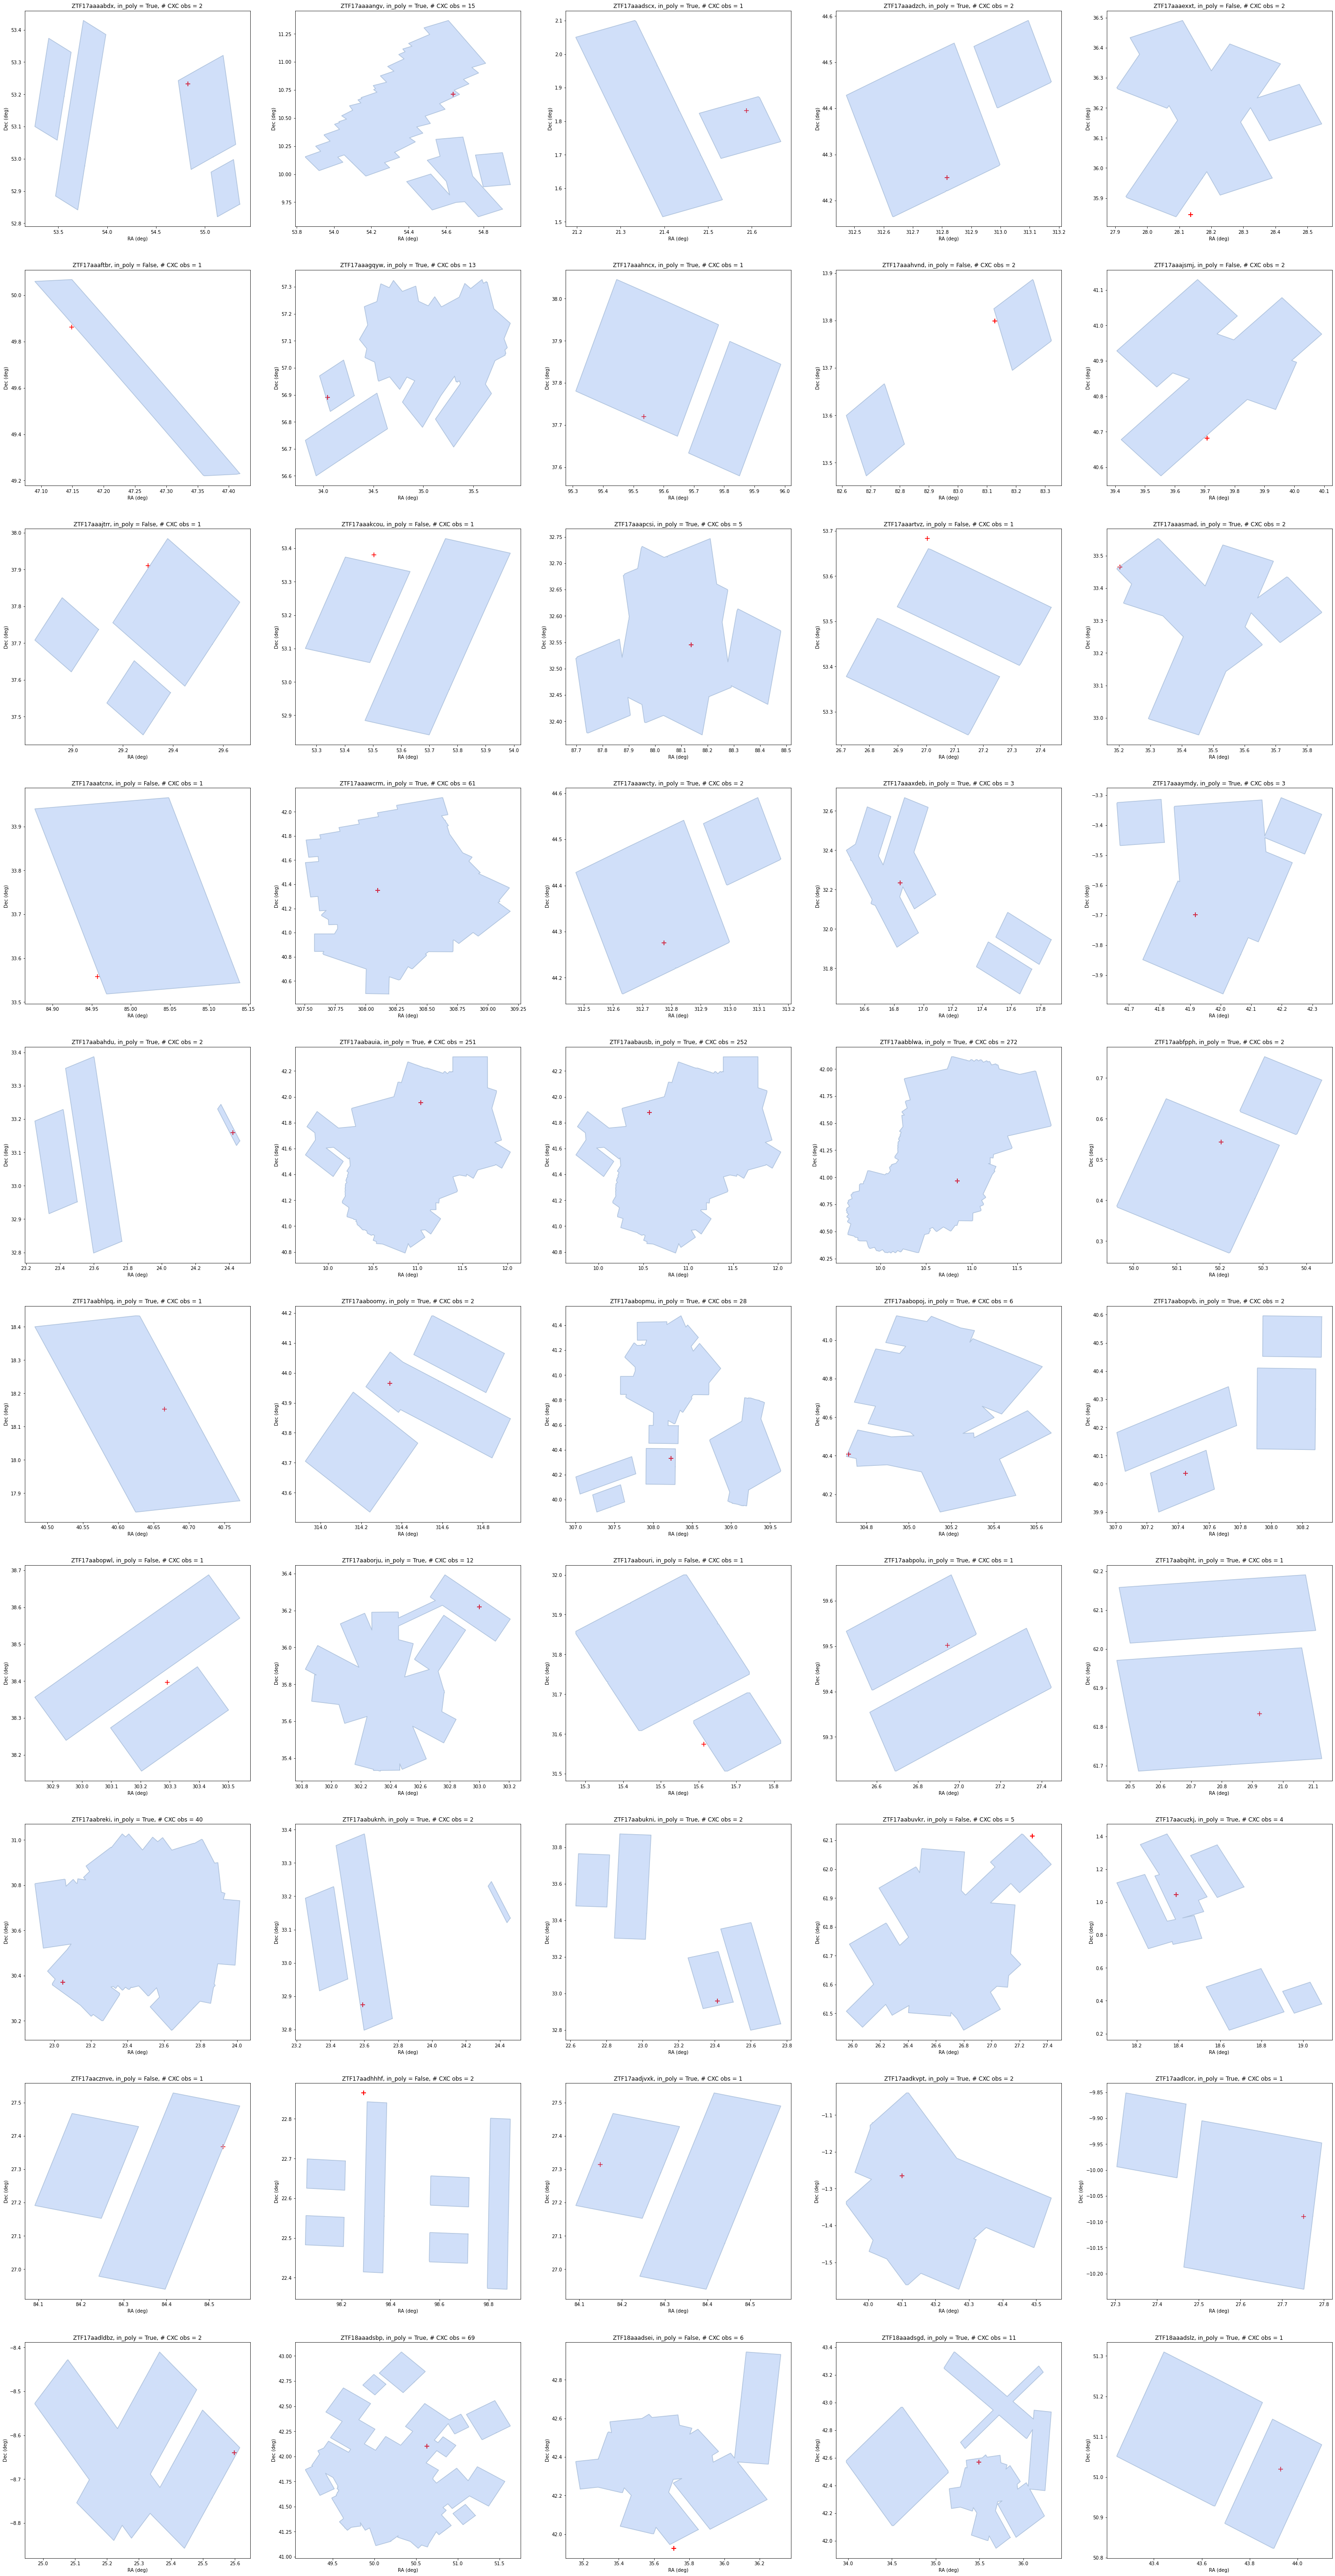

In [15]:
# Example plots of ZTF objects, their corresponding cone search matches and footprint regions
nplots=50
nrows=10
ncols=5

start = 0
stop = start + nplots
testoids = range(start, stop)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*10,nrows*10))
counts = np.arange(nplots).reshape((nrows, ncols))

for idx, i in enumerate(testoids):
    group = obsztfoids.groups[i]
    group.sort('cxc_obs_id')
    polygons = []
    
    ax_ind = np.concatenate(np.where(counts == idx))
    ax = axs[ax_ind[0], ax_ind[1]]

    if (len(group['cxc_s_region'])==1):
        region = group['cxc_s_region'][0].decode()
        s_region = region.replace(")","").split('POLYGON')
        polygon_coords = [np.stack((a.split()[::2], a.split()[1::2]), axis=-1).astype(float) for a in s_region[1:]]
        polygons += [sg.Polygon(c) for c in polygon_coords]
        new_shape = so.unary_union(polygons)
    else:
        for region in group['cxc_s_region'].filled():
            s_region = region.decode().replace(")","").split('POLYGON')
            polygon_coords = [np.stack((a.split()[::2], a.split()[1::2]), axis=-1).astype(float) for a in s_region[1:]]
            polygons += [sg.Polygon(c) for c in polygon_coords]

    new_shape = so.unary_union(polygons)

    if type(new_shape)==type(sg.MultiPolygon()):
        for geom in new_shape.geoms:
            ax.plot(*geom.exterior.xy, color='lightsteelblue')
            ax.fill(*geom.exterior.xy, alpha=0.3, fc='cornflowerblue', ec='none')
    else:
        ax.plot(*new_shape.exterior.xy, color='lightsteelblue')
        ax.fill(*new_shape.exterior.xy, alpha=0.3, fc='cornflowerblue', ec='none')


    x=group['cxc_s_ra'].filled().astype(float)
    y=group['cxc_s_dec'].filled().astype(float)
    color_col = Column(data=[idx for idx, k in enumerate(group['cxc_obs_id'])], name='plot_colors')
    ax.scatter(x=x,
               y=y,
               marker='o', alpha=0.5, c=color_col, s=50)
   
    a,b = np.asarray([group['meanra'], group['meandec']]).astype(float)
    ax.scatter(a,b, marker='+', color='red', s=100)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    
    #Formatting title
    inpoly = str((True in group['in_poly']))
    cxc_obsids = str(len(group['cxc_obs_id'].astype(str)))
    title = group.groups.keys[0] + ', in_poly = '+ inpoly + ', # CXC obs = ' + cxc_obsids
    ax.set_title(title)

plt.savefig("footprint_plots_LC-TEST.pdf")
plt.show()